# Применения нейронной сети Кохонена

## Цветовая самоорганизующаяся карта

In [1]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])

som = MiniSom(20, 30, 3, sigma=3, learning_rate=0.5, neighborhood_function='gaussian')
som.train_random(colors, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.1574485278020972e-05
 topographic error: 0.0


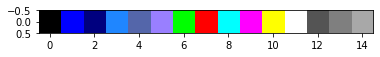

In [2]:
plt.imshow([colors]);

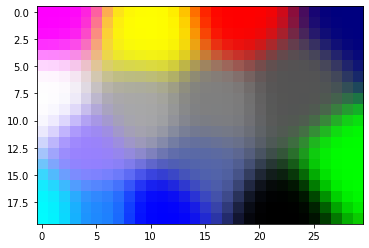

In [3]:
plt.imshow(abs(som.get_weights()));

## Классификация при помощи сети Кохонена

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
data = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))[1:]
data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)
labels = np.genfromtxt('iris.csv', delimiter=',', usecols=(4), dtype=str)[1:]

# Initialization and training
som = MiniSom(7, 7, 4, sigma=3, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)
som.train(data, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 7.916278445489815e-05
 topographic error: 0.18666666666666668


In [6]:
# Количество элементов каждого класса, для которых нейрон с координатами (i,j) является победителем
# Т.е. отображение классов ОВ на нейроны сетки
class_assignments = som.labels_map(data, labels)
class_assignments

defaultdict(list,
            {(1, 5): Counter({'setosa': 9}),
             (2, 4): Counter({'setosa': 9}),
             (2, 5): Counter({'setosa': 4}),
             (1, 6): Counter({'setosa': 7}),
             (2, 6): Counter({'setosa': 4}),
             (0, 5): Counter({'setosa': 3}),
             (0, 6): Counter({'setosa': 4}),
             (0, 4): Counter({'setosa': 2}),
             (0, 3): Counter({'setosa': 2}),
             (1, 4): Counter({'setosa': 5}),
             (1, 3): Counter({'setosa': 1}),
             (2, 2): Counter({'versicolor': 8}),
             (4, 6): Counter({'versicolor': 6}),
             (2, 1): Counter({'versicolor': 3}),
             (2, 0): Counter({'versicolor': 4}),
             (3, 0): Counter({'versicolor': 4}),
             (4, 5): Counter({'versicolor': 3}),
             (1, 1): Counter({'versicolor': 5}),
             (1, 0): Counter({'versicolor': 2}),
             (0, 0): Counter({'versicolor': 2}),
             (1, 2): Counter({'versicolor': 2}

In [7]:
def classify(som, data, class_assignments):
    winmap = class_assignments
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        # Для классификации определяем нейрон-победитель
        win_position = som.winner(d)
        # Если он есть в списке выше, то берем наиболее распространенный класс, отображенный на него
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        # Если на нейрон-победитель не отображен ни один элемент ОВ, то берем класс по умолчанию - 
        # самый распространенный в выборке
        # Можно реализовать и другие эвристики - например, ближайший нейрон с известным классом или 
        # наиболее распространенный класс из окрестности данного нейрона
        else:
            result.append(default_class)
    return result

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels)

som.pca_weights_init(X_train)
som.train_random(X_train, 5000, verbose=False)
class_assignments = som.labels_map(X_train, y_train)

print(classification_report(y_test, classify(som, X_test, class_assignments)))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        14
  versicolor       0.90      0.90      0.90        10
   virginica       0.93      0.93      0.93        14

    accuracy                           0.95        38
   macro avg       0.94      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38



## Распознавание рукописных букв

In [36]:
from sklearn import datasets
from sklearn.preprocessing import scale

digits = datasets.load_digits(n_class=10)
data = digits.data  # изображения цифр - 1797 образцов, 8х8 пикселей
data = scale(data)
num = digits.target   # метки - цифры

som = MiniSom(30, 30, 64, sigma=4, learning_rate=0.5, neighborhood_function='triangle')
som.pca_weights_init(data)
som.train_random(data, 5000, verbose=True)  # random training

 [ 4812 / 5000 ]  96% - 0:00:00 left  [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.15995469857067984
 topographic error: 0.13912075681691707


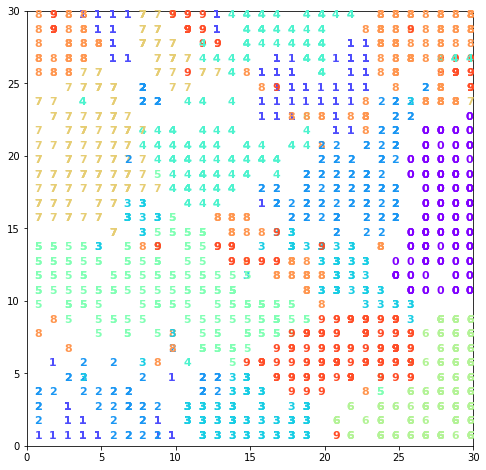

In [37]:
plt.figure(figsize=(8, 8))
for x, t in zip(data, num):
    w = som.winner(x)
    plt.text(w[0]+.5,  w[1]+.5,  str(t), color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()


In [35]:
# Для дальнейшей классификации можно использовать эвристику из предыдущего примера

## Выявление выбросов в данных

In [14]:
from sklearn.datasets import make_blobs

In [24]:
# Сгенерируем выборку с выраженными кластерами и шумом (35%)
outliers_percentage = 0.35
inliers = 300
outliers = int(inliers * outliers_percentage)
# Генерируем полезные данные 
data = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[.3, .3],
                  n_samples=inliers, random_state=0)[0]
data = scale(data)
# Генерируем шум
data = np.concatenate([data, 
                       (np.random.rand(outliers, 2)-.5)*4.])
# Создаем карту с 2 нейронами (по числу кластеров)
som = MiniSom(2, 1, data.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)
som.train_batch(data, 100, verbose=True)  # random training

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.25679533465102944
 topographic error: 0.0


/opt/conda/lib/python3.7/site-packages/minisom.py:145: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


In [30]:
# Критерий принадлежности к кластеру - ошибка квантизации, не превосходящая порог
quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)
# В качестве порога берем процентиль
error_treshold = np.percentile(quantization_errors, 65)
is_outlier = quantization_errors > error_treshold

Text(0, 0.5, 'frequency')

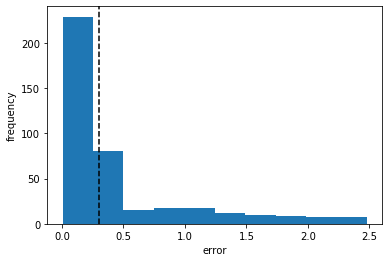

In [31]:
# Построим гистограмму ошибок квантизации
plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

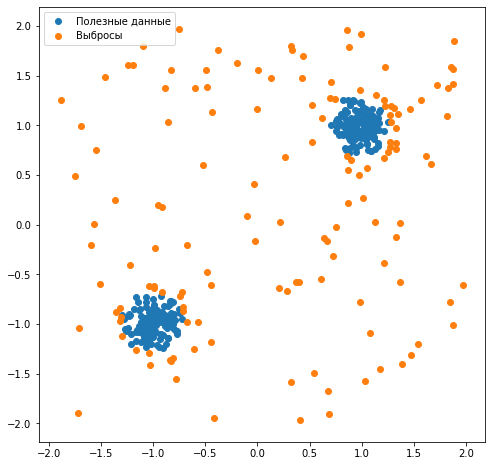

In [34]:
plt.figure(figsize=(8, 8))
plt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],
            label='Полезные данные')
plt.scatter(data[is_outlier, 0], data[is_outlier, 1],
            label='Выбросы')
plt.legend()
plt.show()